In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from intrinsic_alignments.project_settings import PROJECT_DIRECTORY
%matplotlib inline

# Illustris Alignment Strength

In [89]:
# Load TNMG300 galaxy catalog

from Illustris_Shapes.simulation_props import sim_prop_dict

simname = 'TNG300-1'
snapnum = 99
shape_type = 'iterative'

d = sim_prop_dict[simname]
Lbox = d['Lbox']

In [90]:
from astropy.table import Table
fpath = PROJECT_DIRECTORY + 'data/Illustris/'

# load VAGC
fname = 'value_added_catalogs/' + simname + '_' + str(snapnum) + '_vagc.dat'
vagc_galaxy_table = Table.read(fpath + fname, format='ascii')

# load galaxy shape catalog
fname = 'shape_catalogs/' + simname + '_' + str(snapnum) + '_' + shape_type + '_galaxy_shapes.dat'
galaxy_shape_table = Table.read(fpath + fname, format='ascii')

# load halo shape catalog
fname = 'shape_catalogs/' + simname + '_' + str(snapnum) + '_' + shape_type + '_halo_shapes.dat'
halo_shape_table = Table.read(fpath + fname, format='ascii')

# join galaxy shape and vagc tables
from astropy.table import join
galaxy_table = join(vagc_galaxy_table, galaxy_shape_table)
for key in galaxy_table.keys():
    print(key)

gal_id
host_halo_id
central_id
x
y
z
vx
vy
vz
stellar_mass_in_twice_halfrad
stellar_mass_all
host_halo_mass_200m
host_halo_radius_200m
host_halo_fof_mass
a
b
c
av_x
av_y
av_z
bv_x
bv_y
bv_z
cv_x
cv_y
cv_z


In [91]:
# add halo properties
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['gal_id'],halo_shape_table['halo_id'])

galaxy_table['halo_a'] = -1.0
galaxy_table['halo_b'] = -1.0
galaxy_table['halo_c'] = -1.0

galaxy_table['halo_a'][idx] = halo_shape_table['a'][idy]
galaxy_table['halo_b'][idx] = halo_shape_table['b'][idy]
galaxy_table['halo_c'][idx] = halo_shape_table['c'][idy]

galaxy_table['halo_av_x'] = -1.0
galaxy_table['halo_av_y'] = -1.0
galaxy_table['halo_av_z'] = -1.0

galaxy_table['halo_bv_x'] = -1.0
galaxy_table['halo_bv_y'] = -1.0
galaxy_table['halo_bv_z'] = -1.0

galaxy_table['halo_cv_x'] = -1.0
galaxy_table['halo_cv_y'] = -1.0
galaxy_table['halo_cv_z'] = -1.0

galaxy_table['halo_av_x'][idx] = halo_shape_table['av_x'][idy]
galaxy_table['halo_av_y'][idx] = halo_shape_table['av_y'][idy]
galaxy_table['halo_av_z'][idx] = halo_shape_table['av_z'][idy]

galaxy_table['halo_bv_x'][idx] = halo_shape_table['bv_x'][idy]
galaxy_table['halo_bv_y'][idx] = halo_shape_table['bv_y'][idy]
galaxy_table['halo_bv_z'][idx] = halo_shape_table['bv_z'][idy]

galaxy_table['halo_cv_x'][idx] = halo_shape_table['cv_x'][idy]
galaxy_table['halo_cv_y'][idx] = halo_shape_table['cv_y'][idy]
galaxy_table['halo_cv_z'][idx] = halo_shape_table['cv_z'][idy]

In [92]:
coords = np.vstack((galaxy_table['x'],
                    galaxy_table['y'],
                    galaxy_table['z'])).T/1000.0

# galaxy major_axis
gal_orientations_major = np.vstack((galaxy_table['av_x'],
                                galaxy_table['av_y'],
                                galaxy_table['av_z'])).T

# galaxy major_axis
gal_orientations_minor = np.vstack((galaxy_table['cv_x'],
                                galaxy_table['cv_y'],
                                galaxy_table['cv_z'])).T

# halo major_axis
halo_orientations_major = np.vstack((galaxy_table['halo_av_x'],
                                galaxy_table['halo_av_y'],
                                galaxy_table['halo_av_z'])).T

# halo major_axis
halo_orientations_minor = np.vstack((galaxy_table['halo_cv_x'],
                                galaxy_table['halo_cv_y'],
                                galaxy_table['halo_cv_z'])).T

In [93]:
from intrinsic_alignments.ia_models.ia_model_components import inverse_alignment_strength
from rotations.vector_utilities import angles_between_list_of_vectors

In [94]:
selection_mask = galaxy_table['stellar_mass_all']>10**10.5
print('number of galaxies in selection: ', np.sum(selection_mask))

number of galaxies in selection:  24433


In [95]:
centrals = (galaxy_table['gal_id']==galaxy_table['central_id'])

da = angles_between_list_of_vectors(gal_orientations_major, halo_orientations_major)
da = da[selection_mask & centrals]

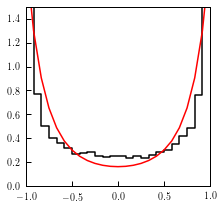

alignment strength:  [0.75504076]


In [96]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [97]:
mu_1_cen = inverse_alignment_strength(k)

In [98]:
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['central_id'], galaxy_table['gal_id'])

satellites = (galaxy_table['gal_id']!=galaxy_table['central_id'])

from intrinsic_alignments.utils.vector_utilities import pbc_radial_vector
r = pbc_radial_vector(coords[idx], coords[idy], Lbox=Lbox)
galaxy_table['r_x'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_y'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_z'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_x'][idx] = r[:,0]
galaxy_table['r_y'][idx] = r[:,1]
galaxy_table['r_z'][idx] = r[:,2]
galaxy_table['mag_r'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['mag_r'] = np.sum(galaxy_table['r_x']**2 + galaxy_table['r_y']**2 +galaxy_table['r_z']**2)

r = np.vstack((galaxy_table['r_x'], galaxy_table['r_y'], galaxy_table['r_z'])).T
da = angles_between_list_of_vectors(gal_orientations_major, r)
da = da[satellites & (~np.isnan(da)) & selection_mask]

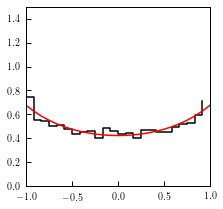

alignment strength:  [0.27935947]


In [99]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [100]:
mu_1_sat = inverse_alignment_strength(k)

In [101]:
selection_mask = galaxy_table['stellar_mass_all']>10**10.0
print('number of galaxies in selection: ', np.sum(selection_mask))

number of galaxies in selection:  76125


In [102]:
centrals = (galaxy_table['gal_id']==galaxy_table['central_id'])

da = angles_between_list_of_vectors(gal_orientations_major, halo_orientations_major)
da = da[selection_mask & centrals]

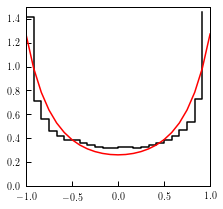

alignment strength:  [0.64093213]


In [103]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [104]:
mu_2_cen = inverse_alignment_strength(k)

In [105]:
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['central_id'], galaxy_table['gal_id'])

satellites = (galaxy_table['gal_id']!=galaxy_table['central_id'])

from intrinsic_alignments.utils.vector_utilities import pbc_radial_vector
r = pbc_radial_vector(coords[idx], coords[idy], Lbox=Lbox)
galaxy_table['r_x'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_y'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_z'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_x'][idx] = r[:,0]
galaxy_table['r_y'][idx] = r[:,1]
galaxy_table['r_z'][idx] = r[:,2]
galaxy_table['mag_r'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['mag_r'] = np.sum(galaxy_table['r_x']**2 + galaxy_table['r_y']**2 +galaxy_table['r_z']**2)

r = np.vstack((galaxy_table['r_x'], galaxy_table['r_y'], galaxy_table['r_z'])).T
da = angles_between_list_of_vectors(gal_orientations_major, r)
da = da[satellites & (~np.isnan(da)) & selection_mask]

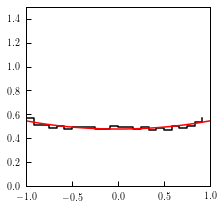

alignment strength:  [0.08497533]


In [106]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [107]:
mu_2_sat = inverse_alignment_strength(k)

In [108]:
selection_mask = galaxy_table['stellar_mass_all']>10**9.5
print('number of galaxies in selection: ', np.sum(selection_mask))

number of galaxies in selection:  146073


In [109]:
centrals = (galaxy_table['gal_id']==galaxy_table['central_id'])

da = angles_between_list_of_vectors(gal_orientations_major, halo_orientations_major)
da = da[selection_mask & centrals]

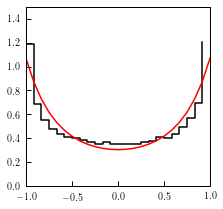

alignment strength:  [0.57172919]


In [110]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [111]:
mu_3_cen = inverse_alignment_strength(k)

In [112]:
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['central_id'], galaxy_table['gal_id'])

satellites = (galaxy_table['gal_id']!=galaxy_table['central_id'])

from intrinsic_alignments.utils.vector_utilities import pbc_radial_vector
r = pbc_radial_vector(coords[idx], coords[idy], Lbox=Lbox)
galaxy_table['r_x'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_y'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_z'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_x'][idx] = r[:,0]
galaxy_table['r_y'][idx] = r[:,1]
galaxy_table['r_z'][idx] = r[:,2]
galaxy_table['mag_r'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['mag_r'] = np.sum(galaxy_table['r_x']**2 + galaxy_table['r_y']**2 +galaxy_table['r_z']**2)

r = np.vstack((galaxy_table['r_x'], galaxy_table['r_y'], galaxy_table['r_z'])).T
da = angles_between_list_of_vectors(gal_orientations_major, r)
da = da[satellites & (~np.isnan(da)) & selection_mask]

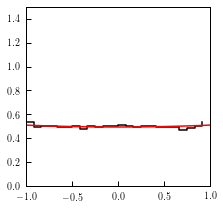

alignment strength:  [0.01995]


In [113]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [114]:
mu_3_sat = inverse_alignment_strength(k)

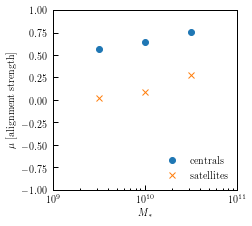

In [123]:
m_thresh = 10**np.array([9.5,10.0,10.5])

fig = plt.figure(figsize=(3.3,3.3))
p1, = plt.plot(m_thresh,[mu_3_cen, mu_2_cen, mu_1_cen], 'o')
p2, = plt.plot(m_thresh,[mu_3_sat, mu_2_sat, mu_1_sat], 'x')
plt.xscale('log')
plt.xlim([10**9,10**11.0])
plt.ylim([-1,1])
plt.ylabel(r'$\mu~[{\rm alignment~strength}]$')
plt.xlabel(r'$M_{*}$')
plt.legend([p1,p2],['centrals','satellites'],frameon=False, fontsize=10, loc='lower right')
plt.show()

fname = 'samples_alignment_strength.pdf'
fpath = PROJECT_DIRECTORY + 'modelling_illustris/figures/'
fig.savefig(fpath+fname, dpi=250)

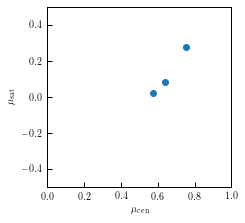

In [124]:
plt.figure(figsize=(3.3,3.3))
p1, = plt.plot([mu_3_cen, mu_2_cen, mu_1_cen],[mu_3_sat, mu_2_sat, mu_1_sat], 'o')
plt.xlim([0,1])
plt.ylim([-0.5,0.5])
plt.xlabel(r'$\mu_{\rm cen}$')
plt.ylabel(r'$\mu_{\rm sat}$')
plt.show()